In [1]:
import sys
sys.path.append('../data')
sys.path.append('../data/low')
sys.path.append('../data/mid')
sys.path.append('../Librerias')

import dataset as ds
import utils
import caract as dc


import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
import copy

from os import listdir
from os.path import isfile, join
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

import scipy.signal as signal


sns.set_style("darkgrid")

In [2]:
fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/high/"
#fpath =  "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/high/"
onlyfiles = [f for f in listdir(fpath) if isfile(join(fpath, f))]

cutoff = [8/1000, 11/1000]


# **high frames**

In [3]:
#load data
frames = []
for fname in onlyfiles:
    if fname.endswith(".mat"):
        set =  ds.MatFileToDataFrame(fpath, fname)
        df = set.get_dataframe(cutoff)
        frames.append(df)
        print(fname)

high8_090124.mat
high5_100124.mat
high10_090124.mat
high10_100124.mat
high8_100124.mat
high5_090124.mat
high2_100124.mat
high7_100124.mat
high12_090124.mat
high7_090124.mat
high9_090124.mat
high9_100124.mat
high4_090124.mat
high1_090124.mat
high1_100124.mat
high6_100124.mat
high3_090124.mat
high3_100124.mat


In [4]:
defectos_frames = []
taus = []
for i, df in enumerate(frames):
    aux = dc.CaractDefect(df)
    defectos_frames.append(aux)
    taus.append(aux.get_tau()[1])
    sys.stdout.write(str(i) + '\r')

In [5]:
hilbert_frames = []
for i, df in enumerate(defectos_frames):
    aux, _ = df.get_hilbert()
    hilbert_frames.append(aux)
    sys.stdout.write(str(i) + '\r')

**dataframe con defectos**

In [6]:
# dataframe con defectos
frames_cd = []

for i in range(len(frames)):
    frames_cd.append(pd.merge(frames[i], hilbert_frames[i], on='Hilbert Transform', how='outer'))

frames_cd[0]

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,0.892414,0.286351,0.035339,0.035339-0.029502j,0.046035,-0.695619,-0.031476
1,0.905895,0.299832,0.033637,0.033637-0.002503j,0.033730,-0.074284,-0.002016
2,0.917075,0.311011,0.031906,0.031906-0.000839j,0.031917,-0.026296,0.025766
3,0.930556,0.324492,0.030149,0.030149+0.008867j,0.031426,0.286053,0.050336
4,0.939105,0.333041,0.028367,0.028367+0.010115j,0.030117,0.342504,0.070494
...,...,...,...,...,...,...,...
599995,0.371251,-0.234812,-0.003465,-0.003465-0.005847j,0.006797,18853.733329,0.147866
599996,0.348564,-0.257500,-0.003298,-0.003298-0.004618j,0.005674,18853.648171,0.158010
599997,0.344618,-0.261446,-0.003127,-0.003127-0.011439j,0.011859,18854.001503,0.167368
599998,0.325218,-0.280845,-0.002952,-0.002952-0.009812j,0.010247,18853.976039,0.175975


**dataframe sin defectos**

In [7]:
signal_nd = []
hilbert_nd = []
for i, elem in enumerate(defectos_frames):
    x, y = elem.get_no_defectos()
    signal_nd.append(x)
    hilbert_nd.append(y)
    sys.stdout.write(str(i) + '\r')

In [8]:
display(signal_nd[0].head())
display(hilbert_nd[0].head())

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform
0,0.892414,0.286351,0.035339,0.035339-0.029502j
1,0.905895,0.299832,0.033637,0.033637-0.002503j
2,0.917075,0.311011,0.031906,0.031906-0.000839j
3,0.930556,0.324492,0.030149,0.030149+0.008867j
4,0.939105,0.333041,0.028367,0.028367+0.010115j


,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,0.035339-0.029502j,0.046035,-0.695619,-0.031476
1,0.033637-0.002503j,0.033730,-0.074284,-0.002016
2,0.031906-0.000839j,0.031917,-0.026296,0.025766
3,0.030149+0.008867j,0.031426,0.286053,0.050336
4,0.028367+0.010115j,0.030117,0.342504,0.070494


**interpolación**

In [9]:
inter_signal_nd = copy.deepcopy(signal_nd)
inter_hilbert_nd = copy.deepcopy(hilbert_nd)


In [10]:
for i, (s1, s2) in enumerate(zip(inter_signal_nd[:2], inter_hilbert_nd[:2])):
    #s1.interpolate('linear', inplace=True)
    #s2.interpolate('linear', inplace=True)
    s1.interpolate('polynomial', order = 3,inplace=True)
    s2.interpolate('polynomial', order = 3 ,inplace=True)
    sys.stdout.write(str(i) + '\r')


In [11]:
hilbert_nd[0].isna().sum(), inter_hilbert_nd[0].isna().sum()

(Hilbert Transform      1600
 Amplitude              1600
 Instantaneous Phase    1600
 Gradient Phase         1600
 dtype: int64,
 Hilbert Transform      0
 Amplitude              0
 Instantaneous Phase    0
 Gradient Phase         0
 dtype: int64)

## defectos

**indices de los defectos**

In [12]:
# obtención de los indices de los defectos

defectos_indices = []
for elem in defectos_frames:
    indices, _ = elem.get_defectos()
    defectos_indices.append(indices)


In [13]:
# arreglo con los DataFrame que tienen los inicios, finales e indice tau de los defectos

tau_indices = []
for elem in defectos_frames:
    tau_indices.append(elem.get_tau_indices())


In [14]:
# arreglo con el inicio y final de los defectos
indices_defectos = []
for elem in tau_indices:
    x = elem[['start', 'end']]
    indices_defectos.append(x.values)

In [15]:
len(indices_defectos)

18

**array con ventanas**

In [16]:
# creo ventanas con 2000 elementos un overlap del 5%
all_windows = []
for elem in frames_cd:
    x = utils.create_windows(elem, 2000, 100)
    all_windows.append(x)

In [17]:
# recupero los indices de las ventanas con defectos
indices_cd = []
for array, indices in zip(all_windows, indices_defectos):
    x = utils.find_windows(indices, array)
    indices_cd.append(x)

unique_indices = []
for elem in indices_cd:
    x = np.unique(elem)
    unique_indices.append(x)


In [18]:
# elimino las ventanas con defectos
windows_sd = []
for windows, indx in zip(all_windows, unique_indices):
    x = [i for j, i in enumerate(windows) if j not in indx]
    windows_sd.append(x)

# **psd (fft con numpy)**
Se toman los psd y dft de las ventanas, se promedian y se comparan con las de la señal completa con los defectos.

In [19]:
def ffts(signal, fs=1000):
    n = len(signal)
    T = 1/fs
    yf = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, d = T)
    psd = np.abs(yf)**2
    return freqs, psd

In [20]:
# todos los valores

psd_all = []
psd_all_mean = []

psd_amp_all = []
psd_amp_all_mean = []

frequency = []

for elem in all_windows:
    psd_aux = []
    f_aux = []
    amp_aux = []
    for window in elem:
        x = window['Filtered Signal'].values
        y = window['Amplitude'].values

        f, xx = ffts(x)
        _, yy = ffts(y)

        psd_aux.append(xx)
        amp_aux.append(yy)
        f_aux.append(f)

    mean_psd = np.mean(psd_aux, axis = 0)
    mean_amp = np.mean(amp_aux, axis = 0)

    psd_all.append(psd_aux)
    psd_all_mean.append(mean_psd)
    psd_amp_all.append(amp_aux)
    psd_amp_all_mean.append(mean_amp)

    frequency.append(np.mean(f_aux, axis=0))

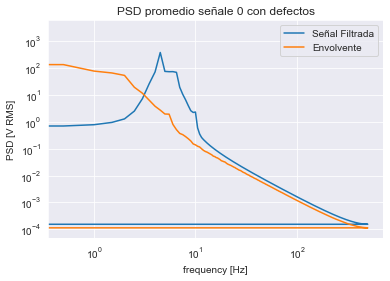

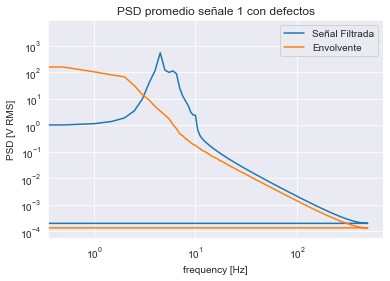

In [21]:
for i, (psd, amp ,freq) in enumerate(zip(psd_all_mean[:2], psd_amp_all_mean[:2],frequency[:2])):
    plt.loglog(freq,psd, label = 'Señal Filtrada')
    plt.loglog(freq, amp, label = 'Envolvente')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V RMS]')
    plt.title(f'PSD promedio señale {i} con defectos')
    plt.legend()
    plt.show()

In [22]:
# valores sin defectos
psd_signal = []
psd_signal_mean = []

psd_amp = []
psd_amp_mean = []

freqs = []

for elem in windows_sd:
    psd_aux = []
    freqs_aux = []
    amp_aux = []
    for window in elem:
        x = window['Filtered Signal'].values
        y = window['Amplitude'].values

        f, xx = ffts(x)
        _, yy = ffts(y)

        psd_aux.append(xx)
        amp_aux.append(yy)
        freqs_aux.append(f)

    mean_psd = np.mean(psd_aux, axis = 0)
    mean_amp = np.mean(amp_aux, axis = 0)

    psd_signal.append(psd_aux)
    psd_signal_mean.append(mean_psd)
    psd_amp.append(amp_aux)
    psd_amp_mean.append(mean_amp)

    freqs.append(np.mean(freqs_aux, axis=0))


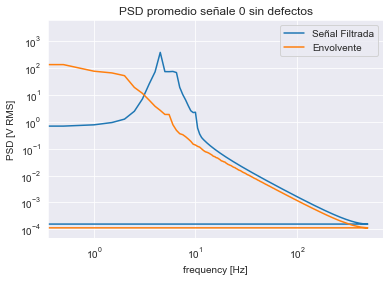

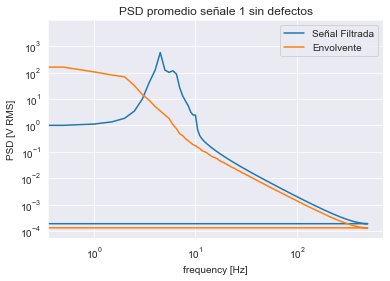

In [23]:

for i, (psd, amp ,freq) in enumerate(zip(psd_signal_mean[:2], psd_amp_mean[:2],freqs[:2])):
    plt.loglog(freq,psd, label = 'Señal Filtrada')
    plt.loglog(freq, amp, label = 'Envolvente')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V RMS]')
    plt.title(f'PSD promedio señale {i} sin defectos')
    plt.legend()
    plt.show()


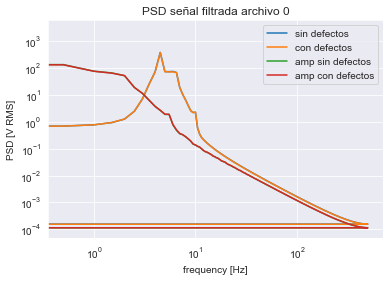

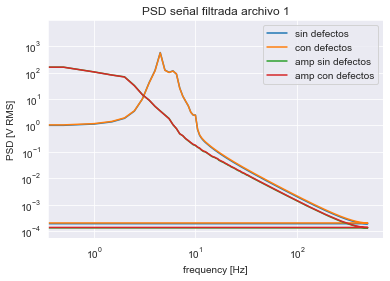

In [24]:
iterables = zip(psd_signal_mean[:2], psd_all_mean[:2], psd_amp_mean[:2], psd_amp_all_mean[:2],freqs[:2], frequency[:2])



for i, (psd_mean, psd_all, amp_mean, amp_all, freq1, freq2) in enumerate(iterables):
    plt.figure
    plt.loglog(freq1,psd_mean, label = 'sin defectos')
    plt.loglog(freq2, psd_all, label = 'con defectos')
    plt.loglog(freq1, amp_mean, label = 'amp sin defectos')
    plt.loglog(freq2, amp_all, label = 'amp con defectos')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V RMS]')
    plt.title(f'PSD señal filtrada archivo {i}')
    plt.legend()
    plt.show()

In [25]:
import plotly.graph_objects as go

iterables = zip(psd_signal_mean[:2], psd_all_mean[:2], psd_amp_mean[:2], psd_amp_all_mean[:2], freqs[:2], frequency[:2])

for i, (psd_mean, psd_all, amp_mean, amp_all, freq1, freq2) in enumerate(iterables):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=freq1, y=psd_mean, name='sin defectos'))
    fig.add_trace(go.Scatter(x=freq2, y=psd_all, name='con defectos'))
    fig.add_trace(go.Scatter(x=freq1, y=amp_mean, name='amp sin defectos'))
    fig.add_trace(go.Scatter(x=freq2, y=amp_all, name='amp con defectos'))
    fig.update_layout(
        title=f'PSD por FFT archivo {i}',
        xaxis_title='frequency [Hz]',
        yaxis_title='PSD [V RMS]',
        legend_title='Legend'
    )
    fig.update_xaxes(type='log')
    fig.update_yaxes(type='log')
    fig.show()


# **welch**

* all_frames -> contiene todos los dataframe de los 19 documentos
* frames_cd -> contiene los dataframe (7 columnas) con los defectos
* signal_nd -> contiene los dataframe de la señal sin los defectos
* hilbert_nd -> contiene los dataframe de hilbert sin los defectos
* all_windows -> contiene todas las ventanas de los 19 documentos
* windows_sd -> contiene las ventanas de los 19 documentos sin las ventanas que tienen defectos.

*regresión lineal o logaritmica de la wea con sklearn para poder ver las diferencias entre pendientes entre las distintas curvas.

In [53]:
# welch todas las señales

iterable = zip(frames_cd, signal_nd, hilbert_nd)

signal_welch_all = []
signal_welch_sd = []
signal_welch_inter = []

amp_welch_all = []
amp_welch_sd = []
amp_wech_inter = []

f1 = []
f2 = []

for i, (df, sig, a) in enumerate(iterable):
    # all signal
    x = df['Filtered Signal'].values
    y = df['Amplitude'].values

    f, all = signal.welch(x, fs=1000, nperseg=2000, scaling='spectrum', window='hamming')
    _, amp = signal.welch(y, fs=1000, nperseg=2000, scaling = 'spectrum', window='hamming')

    signal_welch_all.append(all)
    amp_welch_all.append(amp)

    f1.append(f)

    # defectos
    sig = sig.dropna()
    a = a.dropna()

    x = sig['Filtered Signal'].values
    y = a['Amplitude'].values

    f, psd = signal.welch(x, fs=1000, nperseg=2000, scaling='spectrum', window='hamming')
    _, amp_psd = signal.welch(y, fs=1000, nperseg=2000, scaling='spectrum', window='hamming')

    signal_welch_sd.append(psd)
    amp_welch_sd.append(amp_psd)

    x = inter_signal_nd[i]['Filtered Signal'].values
    y = inter_hilbert_nd[i]['Amplitude'].values

    f, psd = signal.welch(x, fs=1000, nperseg=2000, scaling='spectrum', window='hamming')
    _, amp_psd = signal.welch(y, fs=1000, nperseg=2000, scaling='spectrum', window='hamming')

    signal_welch_inter.append(psd)
    amp_wech_inter.append(amp_psd)

    f2.append(f)



    sys.stdout.write(str(i) + '\r')



In [27]:
#esto esta mal. rabiarabiarabia
ind1 = np.where(f1[1] == 10.0)
ind2 = np.where(f1[1] == 100.0)

ind1, ind2 = ind1[0][0], ind2[0][0]

y = signal_welch_all[1][ind1:ind2]
x = f1[1][ind1:ind2]

slope, intercept =  np.polyfit(x, y,1)

In [28]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=f1[1], y=np.sqrt(signal_welch_all[1]), name='con defectos'))
fig.add_trace(go.Scatter(x=f2[1], y=np.sqrt(signal_welch_sd[1]), name='sin defecto'))
fig.add_trace(go.Scatter(x=x, y = (slope**x)*intercept, name='regresion' ))
#fig.add_trace(go.Scatter(x=f1[1], y=np.sqrt(signal_welch_inter[1]), name='interpolado'))
fig.add_trace(go.Scatter(x=f1[1], y=np.sqrt(amp_welch_all[1]), name='amp con defectos'))
fig.add_trace(go.Scatter(x=f2[1], y=np.sqrt(amp_welch_sd[1]), name='amp sin defectos'))
#fig.add_trace(go.Scatter(x=f1[1], y=np.sqrt(amp_wech_inter[1]), name='amp interpolado'))


fig.update_layout(
    title = 'PSD señal por Welch archivo 1',
    xaxis_title='Frequency [Hz]',
    yaxis_title='Spectrum [V RMS]',
    legend_title='Legend'
)

fig.update_xaxes(type = 'log')
fig.update_yaxes(type = 'log')

fig.show()

/var/folders/st/_pxqq_qx4ys6r36dx2b1zg5w0000gn/T/ipykernel_5577/371721970.py:5: RuntimeWarning:

invalid value encountered in power



In [29]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=f1[1], y=np.sqrt(signal_welch_all[1]), name='con defectos', mode='markers'))
fig.add_trace(go.Scatter(x=f2[1], y=np.sqrt(signal_welch_sd[1]), name='sin defecto',mode='markers'))
fig.add_trace(go.Scatter(x=f1[1], y=np.sqrt(signal_welch_inter[1]), name='interpolado',mode='markers'))
fig.add_trace(go.Scatter(x=f1[1], y=np.sqrt(amp_welch_all[1]), name='amp con defectos',mode='markers'))
fig.add_trace(go.Scatter(x=f2[1], y=np.sqrt(amp_welch_sd[1]), name='amp sin defectos',mode='markers'))
fig.add_trace(go.Scatter(x=f1[1], y=np.sqrt(amp_wech_inter[1]), name='amp interpolado',mode='markers'))


fig.update_layout(
    title = 'PSD señal por Welch archivo 1',
    xaxis_title='Frequency [Hz]',
    yaxis_title='Spectrum [V RMS]',
    legend_title='Legend'
)

fig.update_xaxes(type = 'log')
fig.update_yaxes(type = 'log')

fig.show()


buscar las pendientes y compararlas, entre con defectos y sin defectos para tener comparaciones del contenido espectral.

# **spectogram**


### **all signal**

In [31]:
spect_all = []
spect_sd = []
spect_inter = []

spect_amp_all = []
spect_amp_sd = []
spect_amp_inter = []

t1 = []
f1 = []

t2 = []
f2 = []

t3 = []
f3 = []


for i , (df, sig, amp_sd) in enumerate(zip(frames_cd, signal_nd, hilbert_nd )):
    x = df['Filtered Signal'].values
    y = df['Amplitude'].values

    f_, t_, Sxx = signal.spectrogram(x, fs=1000, nperseg=10000, window = 'hann', scaling='spectrum', mode='magnitude')
    _, _, Syy = signal.spectrogram(y, fs=1000, nperseg = 10000 , window = 'hann', scaling='spectrum', mode='magnitude')

    spect_all.append(Sxx)
    spect_amp_all.append(Syy)
    t1.append(t_)
    f1.append(f_)

    sig = sig.dropna()
    amp_sd = amp_sd.dropna()

    x = sig['Filtered Signal'].values
    y = amp_sd['Amplitude'].values

    f_, t_, Sxx = signal.spectrogram(x, fs=1000, nperseg=10000, window = 'hann', scaling='spectrum', mode='magnitude')
    _, _, Syy = signal.spectrogram(y, fs=1000, nperseg = 10000, window = 'hann', scaling='spectrum', mode='magnitude')

    spect_sd.append(Sxx)
    spect_amp_sd.append(Syy)
    t2.append(t_)
    f2.append(f_)

    x = inter_signal_nd[i]['Filtered Signal'].values
    y = inter_hilbert_nd[i]['Amplitude'].values

    f_, t_, Sxx = signal.spectrogram(x, fs=1000, nperseg=10000, window = 'hann', scaling='spectrum', mode='magnitude')
    _, _, Syy = signal.spectrogram(y, fs=1000, nperseg = 10000, window = 'hann', scaling='spectrum', mode='magnitude')

    spect_inter.append(Sxx)
    spect_amp_inter.append(Syy)
    t3.append(t_)
    f3.append(f_)
    

    sys.stdout.write(str(i) + '\r')



In [52]:

spect_amp_all = []
spect_amp_sd = []
spect_amp_inter = []

t1 = []
f1 = []

t2 = []
f2 = []

t3 = []
f3 = []


for i , (df, sig, amp_sd) in enumerate(zip(frames_cd, signal_nd, hilbert_nd )):
    x = df['Filtered Signal'].values
    y = df['Amplitude'].values

    f_, t_, Sxx = signal.spectrogram(x, fs=1000, nperseg=10000, window = 'hann', scaling='spectrum', mode='magnitude')
    _, _, Syy = signal.spectrogram(y, fs=1000, nperseg = 10000 , window = 'hann', scaling='spectrum', mode='magnitude')

    spect_all.append(Sxx)
    spect_amp_all.append(Syy)
    t1.append(t_)
    f1.append(f_)

    sig = sig.dropna()
    amp_sd = amp_sd.dropna()

    x = sig['Filtered Signal'].values
    y = amp_sd['Amplitude'].values

    f_, t_, Sxx = signal.spectrogram(x, fs=1000, nperseg=10000, window = 'hann', scaling='spectrum', mode='magnitude')
    _, _, Syy = signal.spectrogram(y, fs=1000, nperseg = 10000, window = 'hann', scaling='spectrum', mode='magnitude')

    spect_sd.append(Sxx)
    spect_amp_sd.append(Syy)
    t2.append(t_)
    f2.append(f_)

    x = inter_signal_nd[i]['Filtered Signal'].values
    y = inter_hilbert_nd[i]['Amplitude'].values

    f_, t_, Sxx = signal.spectrogram(x, fs=1000, nperseg=10000, window = 'hann', scaling='spectrum', mode='magnitude')
    _, _, Syy = signal.spectrogram(y, fs=1000, nperseg = 10000, window = 'hann', scaling='spectrum', mode='magnitude')

    spect_inter.append(Sxx)
    spect_amp_inter.append(Syy)
    t3.append(t_)
    f3.append(f_)
    

    sys.stdout.write(str(i) + '\r')



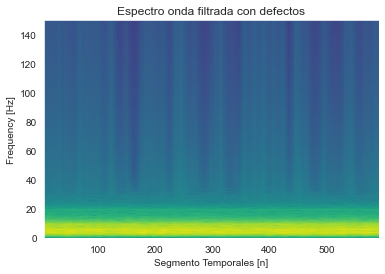

In [33]:
plt.pcolormesh(t1[0], f1[0], spect_all[0], shading='gouraud', cmap='viridis', norm = 'log')
plt.xlabel('Segmento Temporales [n]')
plt.ylabel('Frequency [Hz]')
plt.title('Espectro onda filtrada con defectos')
plt.ylim([0,150])
plt.show()

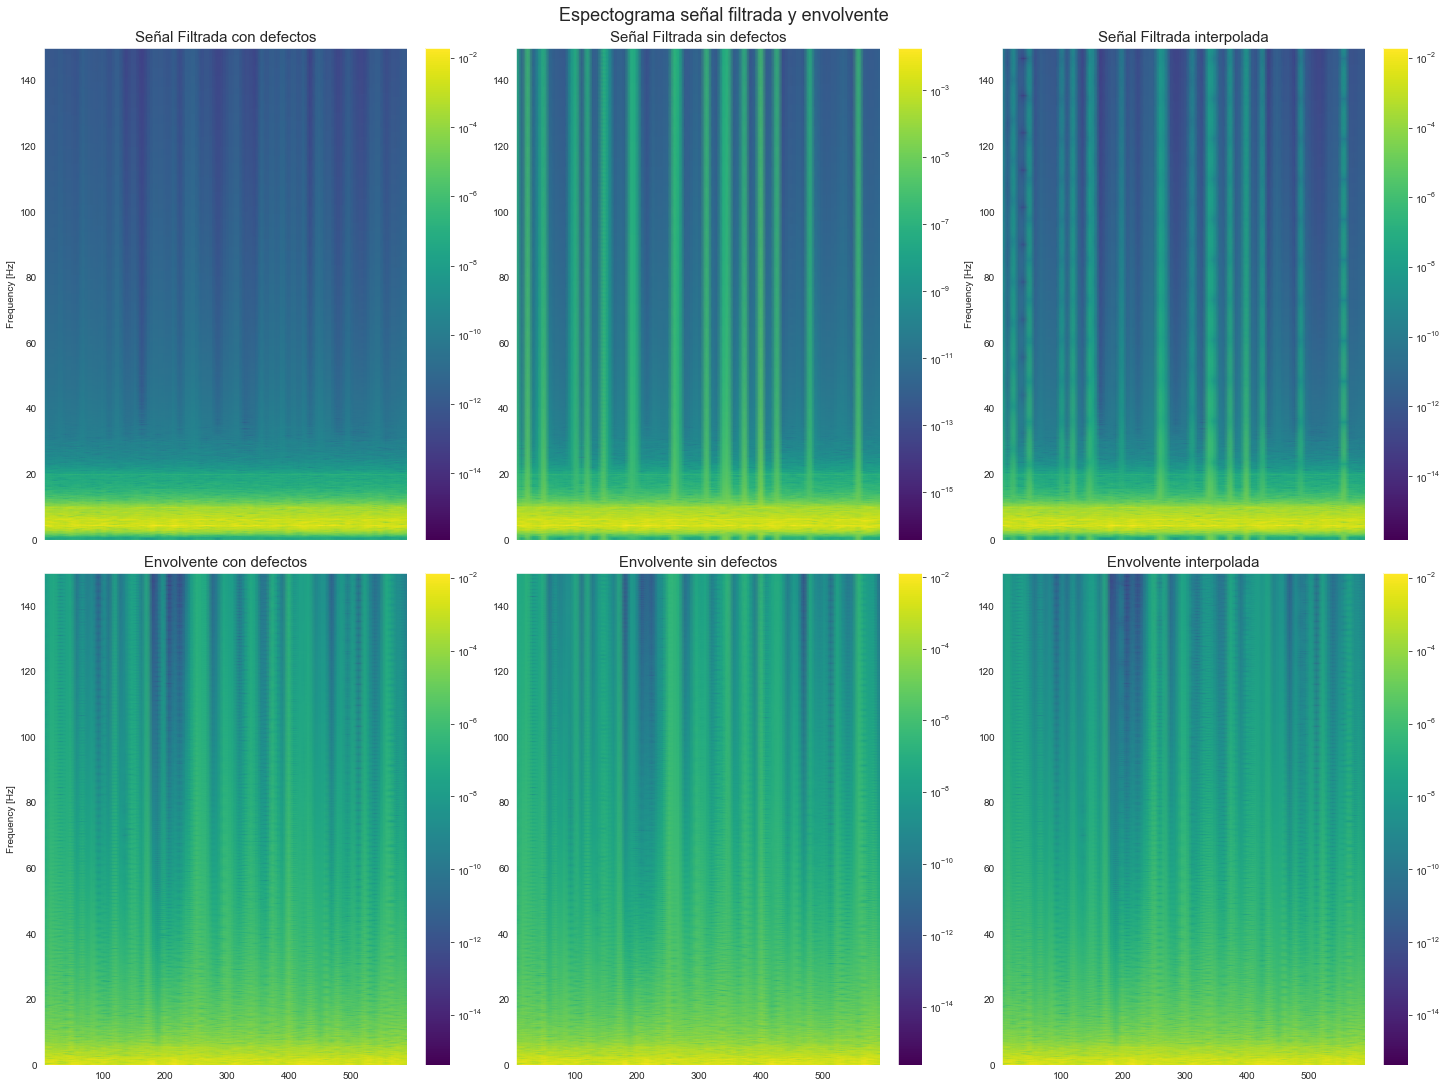

In [34]:
figures, axis = plt.subplots(2,3, sharex=True, constrained_layout=True, figsize = (20,15))
figures.suptitle('Espectograma señal filtrada y envolvente', fontsize=18)

im0 = axis[0,0].pcolormesh(t1[0], f1[0], spect_all[0], shading='gouraud', cmap='viridis', norm = 'log')
axis[0,0].set_title('Señal Filtrada con defectos', fontsize=15)
axis[0,0].set_ylabel('Frequency [Hz]')
axis[0,0].set_ylim([0,150])
figures.colorbar(im0, ax=axis[0,0])

im1 = axis[0,1].pcolormesh(t2[0], f2[0], spect_sd[0], shading='gouraud', cmap='viridis', norm = 'log')
axis[0,1].set_title('Señal Filtrada sin defectos', fontsize=15)
axis[0,1].set_ylim([0,150])
figures.colorbar(im1, ax=axis[0,1])

im2 = axis[1,0].pcolormesh(t1[0], f1[0], spect_amp_all[0], shading='gouraud', cmap='viridis', norm = 'log')
axis[1,0].set_ylabel('Frequency [Hz]')
axis[1,0].set_ylim([0,150])
axis[1,0].set_title('Envolvente con defectos', fontsize=15)
figures.colorbar(im2, ax=axis[1,0])

im3 = axis[1,1].pcolormesh(t2[0], f2[0], spect_amp_sd[0], shading='gouraud', cmap='viridis', norm = 'log')
axis[1,1].set_ylim([0,150])
axis[1,1].set_title('Envolvente sin defectos', fontsize=15)
figures.colorbar(im3, ax=axis[1,1])

im4 = axis[0,2].pcolormesh(t3[0], f3[0], spect_inter[0], shading='gouraud', cmap='viridis', norm = 'log')
axis[0,2].set_ylabel('Frequency [Hz]')
axis[0,2].set_ylim([0,150])
axis[0,2].set_title('Señal Filtrada interpolada', fontsize=15)
figures.colorbar(im4, ax=axis[0,2])

im5 = axis[1,2].pcolormesh(t3[0], f3[0], spect_amp_inter[0], shading='gouraud', cmap='viridis', norm = 'log')
axis[1,2].set_ylim([0,150])
axis[1,2].set_title('Envolvente interpolada', fontsize=15)
figures.colorbar(im5, ax=axis[1,2])

plt.show()

### **windows**

In [35]:
windows_sd[0][0]

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,0.892414,0.286351,0.035339,0.035339-0.029502j,0.046035,-0.695619,-0.031476
1,0.905895,0.299832,0.033637,0.033637-0.002503j,0.033730,-0.074284,-0.002016
2,0.917075,0.311011,0.031906,0.031906-0.000839j,0.031917,-0.026296,0.025766
3,0.930556,0.324492,0.030149,0.030149+0.008867j,0.031426,0.286053,0.050336
4,0.939105,0.333041,0.028367,0.028367+0.010115j,0.030117,0.342504,0.070494
...,...,...,...,...,...,...,...
1995,0.493240,-0.112824,-0.025069,-0.025069+0.000332j,0.025072,59.677034,-0.004959
1996,0.484362,-0.121702,-0.025123,-0.025123-0.000340j,0.025125,59.703796,-0.004910
1997,0.470223,-0.135840,-0.025159,-0.025159-0.001003j,0.025179,59.730113,-0.004862
1998,0.461016,-0.145047,-0.025177,-0.025177-0.001682j,0.025234,59.756970,-0.004813


In [36]:
#spectogram de un documento

w_cd = all_windows[14]
w_sd = windows_sd[14]

X1 = np.zeros([len(w_cd), 129, 8])
X2 = np.zeros([len(w_cd), 129, 8])

Y1 = np.zeros([len(w_sd), 129, 8])
Y2 = np.zeros([len(w_sd), 129, 8])

f_ =[]
t_ = []

f1_ = []
t1_ = []

for i, elem in enumerate(w_sd):
    f, t, Sxx = signal.spectrogram(elem['Filtered Signal'].values, fs=1000, nperseg=256, window = 'hann', scaling='spectrum', mode='magnitude')
    _, _, Syy = signal.spectrogram(elem['Amplitude'].values, fs=1000, nperseg = 256, window = 'hann', scaling='spectrum', mode='magnitude')
    f_ = f
    t_ = t
    X1[i] = Sxx
    X2[i] = Syy

    f, t, Sxx = signal.spectrogram(w_sd[i]['Filtered Signal'].values, fs=1000, nperseg=256, window = 'hann', scaling='spectrum', mode='magnitude')
    _, _, Syy = signal.spectrogram(w_sd[i]['Amplitude'].values, fs=1000, nperseg = 256, window = 'hann', scaling='spectrum', mode='magnitude')
    f1_ = f
    t1_ = t
    Y1[i] = Sxx
    Y2[i] = Syy

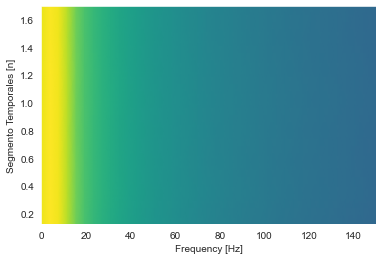

In [37]:
new_X = np.sum(X1, axis=0)
plt.pcolormesh(f_, t_, new_X.T, shading='gouraud', cmap = 'viridis', norm = 'log')
#plt.pcolormesh(x, shading='gouraud', cmap = 'viridis')
plt.ylabel('Segmento Temporales [n]')
plt.xlabel('Frequency [Hz]')
#plt.title('Espectograma en 10 ventanas de 60k datos')
plt.xlim([0,150])
plt.show()

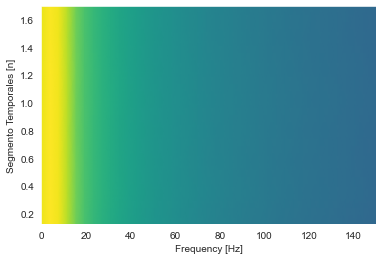

In [38]:
new_X = np.sum(X1, axis=0)
plt.pcolormesh(f_, t_, new_X.T, shading='gouraud', cmap = 'viridis', norm = 'log')
#plt.pcolormesh(x, shading='gouraud', cmap = 'viridis')
plt.ylabel('Segmento Temporales [n]')
plt.xlabel('Frequency [Hz]')
#plt.title('Espectograma en 10 ventanas de 60k datos')
plt.xlim([0,150])
plt.show()

Text(0.5, 1.0, 'Envolvente con defectos')

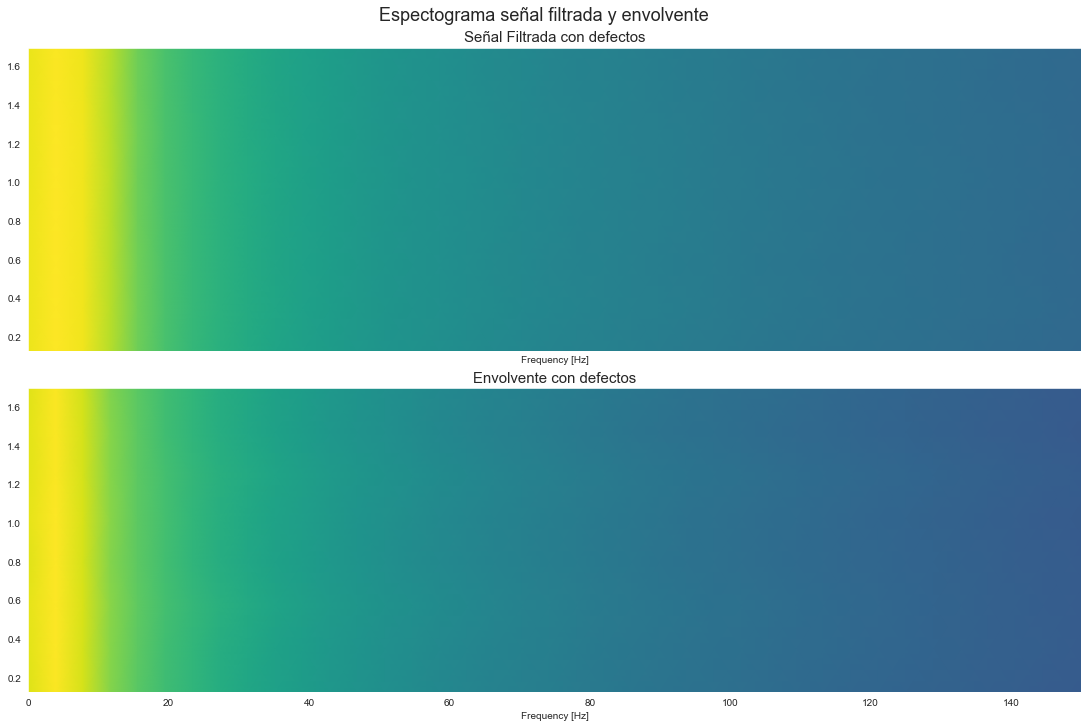

In [39]:
figures, axis = plt.subplots(2,1, sharex=True, constrained_layout=True, figsize = (15,10))
figures.suptitle('Espectograma señal filtrada y envolvente', fontsize=18)

axis[0].pcolormesh(f_, t_, new_X.T, shading='gouraud', cmap='viridis', norm = 'log')
axis[0].set_title('Señal Filtrada con defectos', fontsize=15)
axis[0].set_xlabel('Frequency [Hz]')
axis[0].set_xlim([0,150])

#axis[1,0].pcolormesh(t1_, f1_, np.sum(Y1, axis= 0), shading='gouraud', cmap='viridis', norm = 'log')
#axis[1,0].set_title('Señal Filtrada sin defectos', fontsize=15)
#axis[1,0].set_ylim([0,150])

axis[1].pcolormesh(f_, t_, np.sum(X2, axis= 0).T, shading='gouraud', cmap='viridis', norm = 'log')
axis[1].set_xlabel('Frequency [Hz]')
axis[1].set_xlim([0,150])
axis[1].set_title('Envolvente con defectos', fontsize=15)

#axis[1,1].pcolormesh(t1_, f1_, np.sum(Y2, axis=0), shading='gouraud', cmap='viridis', norm = 'log')
#axis[1,1].set_ylim([0,150])
#axis[1,1].set_title('Envolvente sin defectos', fontsize=15)

Text(0.5, 1.0, 'Envolvente con defectos')

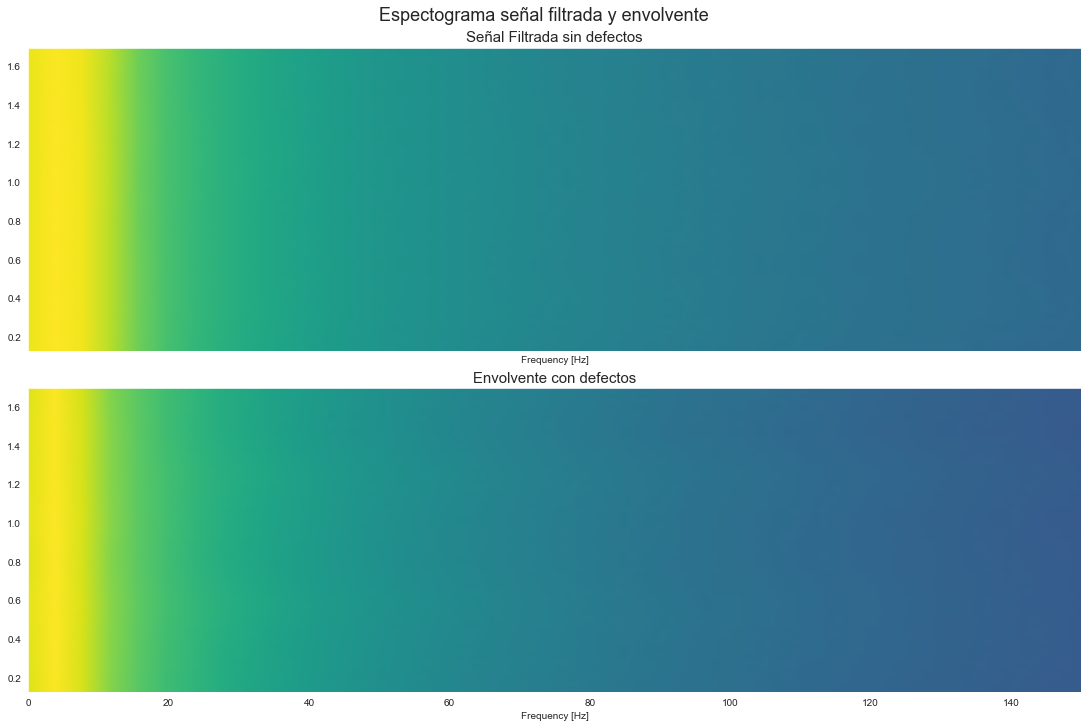

In [40]:
figures, axis = plt.subplots(2,1, sharex=True, constrained_layout=True, figsize = (15,10))
figures.suptitle('Espectograma señal filtrada y envolvente', fontsize=18)

axis[0].pcolormesh(f1_, t1_, np.sum(Y1, axis= 0).T, shading='gouraud', cmap='viridis', norm = 'log')
axis[0].set_title('Señal Filtrada sin defectos', fontsize=15)
axis[0].set_xlabel('Frequency [Hz]')
axis[0].set_xlim([0,150])

#axis[1,0].pcolormesh(t1_, f1_, np.sum(Y1, axis= 0), shading='gouraud', cmap='viridis', norm = 'log')
#axis[1,0].set_title('Señal Filtrada sin defectos', fontsize=15)
#axis[1,0].set_ylim([0,150])

axis[1].pcolormesh(f1_, t1_, np.sum(Y2, axis= 0).T, shading='gouraud', cmap='viridis', norm = 'log')
axis[1].set_xlabel('Frequency [Hz]')
axis[1].set_xlim([0,150])
axis[1].set_title('Envolvente con defectos', fontsize=15)

no hay grandes diferencias. problema: no son del mismo largo por lo que tampoco se  puede operar entre ellos. 

### **interpolación**

# **csv**


In [51]:
len(f1)

18

In [55]:
frames_welch = []

iter = zip(signal_welch_all, signal_welch_sd, amp_welch_all, amp_welch_sd, f1)

for i, (all, sd, amp_all, amp_sd, fq1) in enumerate(iter):
    #cols = ['frequency_1', 'signal_all', 'amplitud_all', 'frequency_2', 'signal_sd', 'amplitude_sd']
    x = pd.DataFrame()
    x['freq1'] = fq1
    
    x['sig_all'] = all
    x['amp_all'] = amp_all

    x['sig_sd'] = sd
    x['amp_sd'] = amp_sd

    frames_welch.append(x)


frames_welch[0].head()

,freq1,sig_all,amp_all,sig_sd,amp_sd
0,0.0,1.409245e-07,0.000011,1.374966e-07,0.000011
1,0.5,1.207680e-07,0.000071,1.196414e-07,0.000071
2,1.0,7.776951e-09,0.000060,1.053415e-08,0.000059
3,1.5,1.022212e-08,0.000046,1.524115e-08,0.000046
4,2.0,4.863105e-08,0.000033,5.712982e-08,0.000033


In [ ]:
#for i, df in enumerate(frames_welch):
#    df.to_csv(f'welch_high{i}.csv')

Tomar la amplitud máxima y tomar todos los datos que cumplan con el 90% y sacar welch de eso y así hasta tener una señal con una curva cambiante